In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Funkcje do wykresów

In [2]:
def find_folders(path):
    """
    Znajduje foldery w danej ścieżce, których nazwa nie zawiera 'val' ani 'predict'.
    """
    folders = [
        folder for folder in os.listdir(path)
        if os.path.isdir(os.path.join(path, folder))
    ]
    result = [
        folder for folder in folders
        if ('val' not in folder.lower()) and ('predict' not in folder.lower())
    ]
    return result

In [3]:
def load_csv_from_folders(folder_names, model_path):
    """
    Wczytuje pliki CSV z każdego folderu i zwraca listę DataFrame’ów.
    Zakłada, że każdy folder zawiera dokładnie jeden plik CSV.

    :param folder_names: lista nazw folderów (bez ścieżki)
    :param model_path: ścieżka bazowa (np. 'yolov10n/runs/detect')
    :return: lista DataFrame’ów
    """
    folder_paths = [os.path.join(model_path, folder) for folder in folder_names]
    dfs = []
    for folder in folder_paths:
        for file in os.listdir(folder):
            if file.endswith('.csv'):
                df = pd.read_csv(os.path.join(folder, file))
                dfs.append(df)
                break  # tylko pierwszy CSV z folderu
    return dfs

In [24]:
def plot_model_metrics(dfs, name, vline_epoch):
    """
    Funkcja rysuje dla każdego DataFrame w liście dfs trzy osobne wykresy:
    1. train/box_loss + val/box_loss
    2. train/cls_loss + val/cls_loss
    3. metrics/precision + metrics/recall + metrics/mAP50 + metrics/mAP50-95

    :param dfs: lista pandas DataFrame'ów
    :param name: nazwa modelu (używana w tytule i nazwie folderu)
    :param vline_epoch: int, pozycja pionowej linii na osi X (epoch)
    """
    metrics = ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
    colors = ['green', 'red', 'purple', 'brown']

    # Tworzymy folder o nazwie 'zdjecia_[name]', jeśli nie istnieje
    folder_name = 'zdjecia_powiekszone_' + name
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    for i, df in enumerate(dfs):
        # Wykres 1: train/box_loss + val/box_loss
        plt.figure(figsize=(8, 5), tight_layout=True)
        if 'train/box_loss' in df.columns and 'val/box_loss' in df.columns:
            epochs_box = np.arange(len(df['train/box_loss']))
            plt.plot(epochs_box, df['train/box_loss'], label='Train Box Loss', color='blue')
            plt.plot(epochs_box, df['val/box_loss'], label='Val Box Loss', color='orange')
            plt.axvline(x=vline_epoch, color='red', linestyle='--', label='Best fit')
            plt.xlabel('Epoch', fontsize=14)
            plt.ylabel('Box Loss', fontsize=14)
            plt.title(f'{name} model {i+1} (Box Loss)', fontsize=17)
            plt.legend(fontsize=13)
            plt.xticks(fontsize=13)
            plt.yticks(fontsize=13)
            plt.grid(True)
            plt.savefig(os.path.join(folder_name, f'{name}_model_{i+1}_box_loss.png'))
            plt.close()
        else:
            print(f'Model {i+1}: Brak kolumn train/box_loss lub val/box_loss')

        # Wykres 2: train/cls_loss + val/cls_loss
        plt.figure(figsize=(8, 5), tight_layout=True)
        if 'train/cls_loss' in df.columns and 'val/cls_loss' in df.columns:
            epochs_cls = np.arange(len(df['train/cls_loss']))
            plt.plot(epochs_cls, df['train/cls_loss'], label='Train Cls Loss', color='blue')
            plt.plot(epochs_cls, df['val/cls_loss'], label='Val Cls Loss', color='orange')
            plt.axvline(x=vline_epoch, color='red', linestyle='--', label='Best fit')
            plt.xlabel('Epoch', fontsize=14)
            plt.ylabel('Cls Loss', fontsize=14)
            plt.title(f'{name} model {i+1} (Cls Loss)', fontsize=17)
            plt.legend(fontsize=13)
            plt.xticks(fontsize=13)
            plt.yticks(fontsize=13)
            plt.grid(True)
            plt.savefig(os.path.join(folder_name, f'{name}_model_{i+1}_cls_loss.png'))
            plt.close()
        else:
            print(f'Model {i+1}: Brak kolumn train/cls_loss lub val/cls_loss')

        # Wykres 3: metrics/precision + metrics/recall + metrics/mAP50 + metrics/mAP50-95
        plt.figure(figsize=(8, 5), tight_layout=True)
        has_metrics = False
        max_len = 0
        for metric in metrics:
            if metric in df.columns:
                max_len = max(max_len, len(df[metric]))

        if max_len > 0:
            epochs_metrics = np.arange(max_len)
            for metric, color in zip(metrics, colors):
                if metric in df.columns:
                    short_name = metric.split('/')[-1].split('(')[0]
                    plt.plot(epochs_metrics[:len(df[metric])], df[metric], label=short_name, color=color)
                    has_metrics = True

            if has_metrics:
                plt.axvline(x=vline_epoch, color='red', linestyle='--', label='Best fit')
                plt.xlabel('Epoch', fontsize=14)
                plt.ylabel('Metric Value', fontsize=14)
                plt.title(f'{name} model {i+1} (Metrics)', fontsize=17)
                plt.legend(fontsize=13)
                plt.xticks(fontsize=13)
                plt.yticks(fontsize=13)
                plt.grid(True)
                plt.savefig(os.path.join(folder_name, f'{name}_model_{i+1}_metrics.png'))
                plt.close()
        else:
            print(f'Model {i+1}: Brak kolumn metryk (precision, recall, mAP)')

## Przerobione wykresy z API YOLO

In [9]:
def smooth(y, f=0.05):
    """Box filter of fraction f."""
    nf = round(len(y) * f * 2) // 2 + 1  # number of filter elements (must be odd)
    p = np.ones(nf // 2)  # ones padding
    yp = np.concatenate((p * y[0], y, p * y[-1]), 0)  # y padded
    return np.convolve(yp, np.ones(nf) / nf, mode="valid")  # y-smoothed

In [10]:
def plot_mc_curve(px, py, names=(), xlabel="Confidence", ylabel="Metric"):
    """Plots a metric-confidence curve."""
    fig, ax = plt.subplots(1, 1, figsize=(9, 6), tight_layout=True)

    if 0 < len(names) < 21:  # display per-class legend if < 21 classes
        for i, y in enumerate(py):
            ax.plot(px, y, linewidth=1, label=f"{names[i]}")  # plot(confidence, metric)
    else:
        ax.plot(px, py.T, linewidth=1, color="grey")  # plot(confidence, metric)

    y = smooth(py.mean(0), 0.05)
    ax.plot(px, y, linewidth=3, color="blue", label=f"all classes {y.max():.2f} at {px[y.argmax()]:.3f}")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True)
    ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    ax.set_title(f"{ylabel}-Confidence Curve")
    plt.show()

## Tabela

In [11]:
def best_map50(dfs):
    """
    Tworzy DataFrame z najlepszymi wynikami fitness dla każdego modelu.
    Fitness = 0.1 * mAP50 + 0.9 * mAP50-95.
    """
    results = []
    for i, df in enumerate(dfs):
        # Jeśli są wymagane kolumny, oblicz fitness dla każdego wiersza
        if 'metrics/mAP50(B)' in df.columns and 'metrics/mAP50-95(B)' in df.columns:
            df = df.copy()
            df['fitness'] = 0.1 * df['metrics/mAP50(B)'] + 0.9 * df['metrics/mAP50-95(B)']
            idx = df['fitness'].idxmax()
            best_row = df.loc[idx].copy()
            best_row['Model'] = f'Model {i+1}'
            results.append(best_row)
        else:
            results.append(pd.Series({'Model': f'Model {i+1}', 'fitness': np.nan}))

    best_df = pd.DataFrame(results)
    if not best_df.empty:
        # Najpierw ustal listę kolumn bez fitness i Model
        cols = [col for col in best_df.columns if col not in ['Model', 'fitness']]
        # Jeśli istnieje metrics/mAP50-95(B), wstaw fitness zaraz za nią
        if 'metrics/mAP50-95(B)' in cols:
            idx = cols.index('metrics/mAP50-95(B)') + 1
            cols.insert(idx, 'fitness')
        else:
            cols.append('fitness')
        # Na początku wstaw Model
        cols = ['Model'] + cols
        best_df = best_df[cols]
    return best_df

# YOLOv10n

In [12]:
name = "YOLOv10n"
path = os.path.join(name.lower(), "runs/detect")
folders = find_folders(path)
dfs = load_csv_from_folders(folders, path)

zdjecia zapisane sa w folderze zdjecia_YOLOv10n

In [25]:
plot_model_metrics(dfs, name, 117)

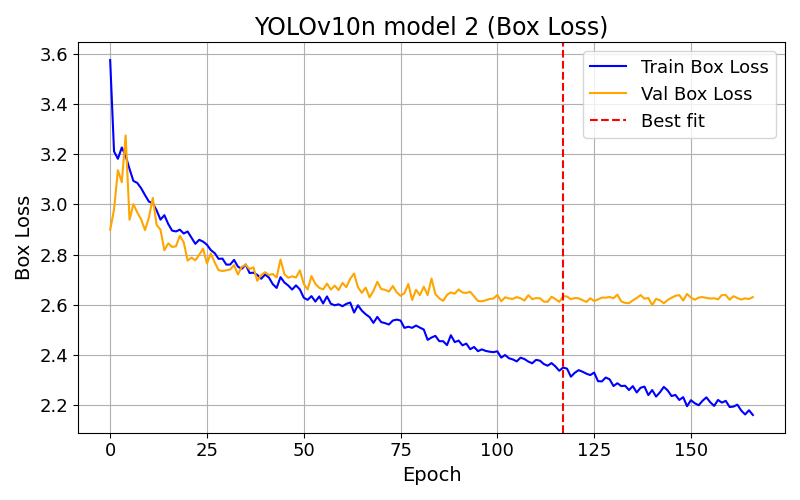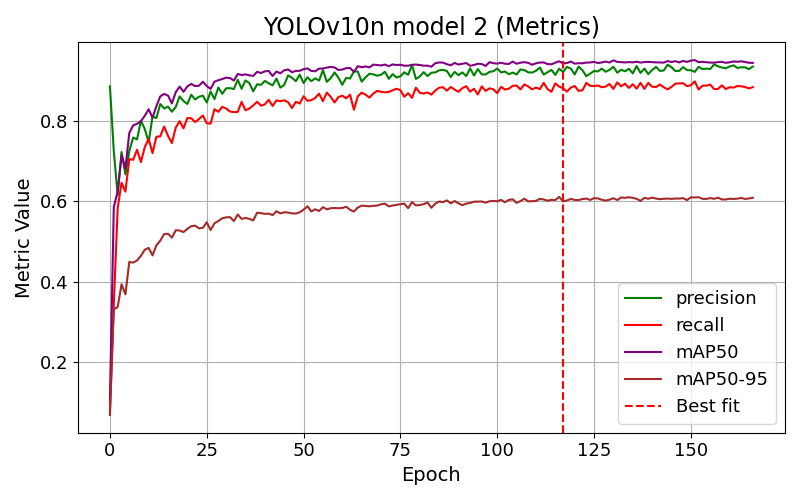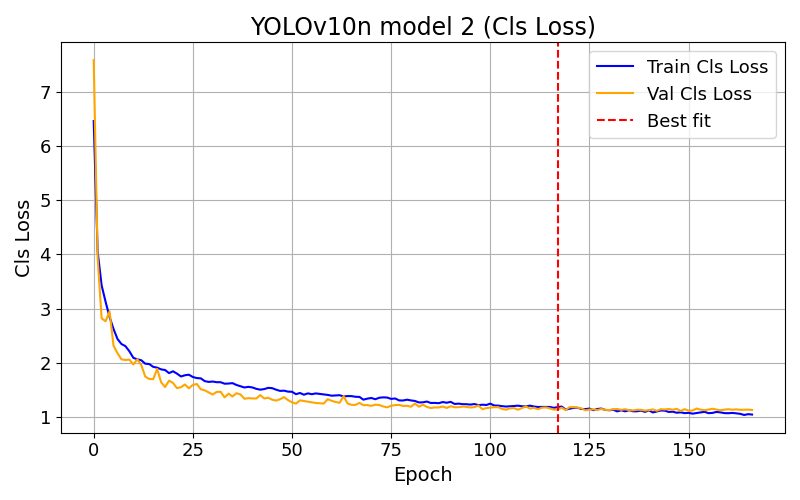

In [14]:
folders

['dataset-v2-1',
 'dataset-v2-22',
 'dataset-v2-finetune-1',
 'dataset-v2-finetune-dfllow-1',
 'train2']

In [15]:
best_map50(dfs)

,Model,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),fitness,val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
89,Model 1,90.0,2412.89,2.25756,1.13013,2.07466,0.91055,0.88543,0.94301,0.60979,0.643112,2.58872,1.11460,2.32010,0.000149,0.000149,0.000149
116,Model 2,117.0,3197.47,2.33640,1.16545,1.40574,0.92933,0.88459,0.94758,0.61054,0.644244,2.61125,1.13118,1.55652,0.000772,0.000772,0.000772
187,Model 3,188.0,4362.63,2.22490,1.13381,2.05355,0.91673,0.88419,0.94365,0.60314,0.637191,2.61175,1.11741,2.33872,0.000093,0.000093,0.000093
86,Model 4,87.0,2262.18,2.39965,1.24738,1.41270,0.90563,0.87566,0.93517,0.59641,0.630286,2.60948,1.17991,1.53697,0.000186,0.000186,0.000186
89,Model 5,90.0,3433.70,2.28594,1.16540,2.08315,0.92430,0.87786,0.94073,0.60679,0.640184,2.57563,1.15930,2.32204,0.000149,0.000149,0.000149


# YOLOv10s

In [26]:
name = "YOLOv10s"
path = os.path.join(name.lower(), "runs/detect")
folders = find_folders(path)
dfs = load_csv_from_folders(folders, path)

In [27]:
folders

['dataset-v2-1',
 'dataset-v2-finetune-1',
 'train',
 'train2',
 'train3',
 'train4',
 'train5',
 'train6',
 'train7']

In [28]:
best_map50(dfs)

,Model,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),fitness,val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
390,Model 1,391.0,15156.30,1.03786,0.43416,1.08682,0.94687,0.89099,0.95602,0.63841,0.670171,2.58992,1.15840,1.59304,0.000347,0.000347,0.000347
154,Model 2,155.0,4997.74,1.89405,0.87847,1.92866,0.93498,0.90558,0.96041,0.62785,0.661106,2.57300,1.02170,2.38226,0.000615,0.000615,0.000615
47,Model 3,48.0,2164.26,2.13558,0.91022,2.08061,0.93217,0.89065,0.95407,0.62692,0.659635,2.50809,1.08142,2.29792,0.000087,0.000087,0.000087
88,Model 4,89.0,4406.34,1.97938,0.90500,1.99238,0.93475,0.90645,0.95615,0.62908,0.661787,2.51478,1.05631,2.35335,0.000161,0.000161,0.000161
49,Model 5,50.0,1878.55,2.33992,1.12548,2.20398,0.92681,0.86484,0.93923,0.60930,0.642293,2.56284,1.17252,2.31187,0.000213,0.000213,0.000213
96,Model 6,97.0,5570.60,2.07745,0.91196,2.06342,0.93488,0.87863,0.94318,0.61439,0.647269,2.56458,1.12194,2.34867,0.000350,0.000350,0.000350
82,Model 7,83.0,3678.28,1.79145,0.82541,1.87929,0.93439,0.90380,0.95440,0.62905,0.661585,2.52951,1.06384,2.31933,0.000031,0.000031,0.000031
36,Model 8,37.0,1663.13,2.19713,1.05490,2.03113,0.93883,0.89002,0.95329,0.62497,0.657802,2.49868,1.08699,2.24677,0.000077,0.000077,0.000077
82,Model 9,83.0,3702.23,1.77671,0.82576,1.86863,0.93288,0.90225,0.95547,0.62897,0.661620,2.53076,1.05909,2.30291,0.000022,0.000022,0.000022


In [29]:
plot_model_metrics(dfs, name, 130)

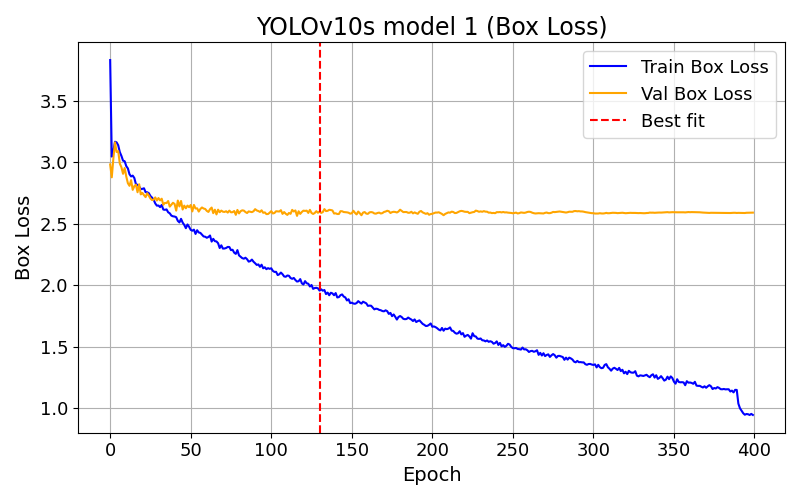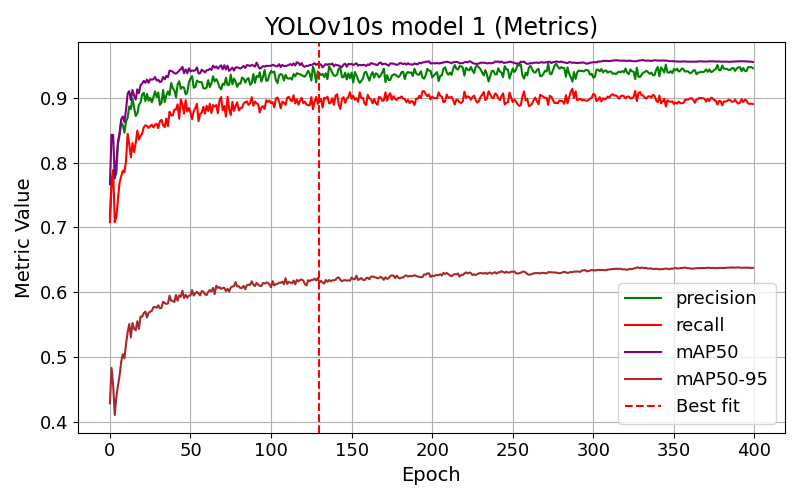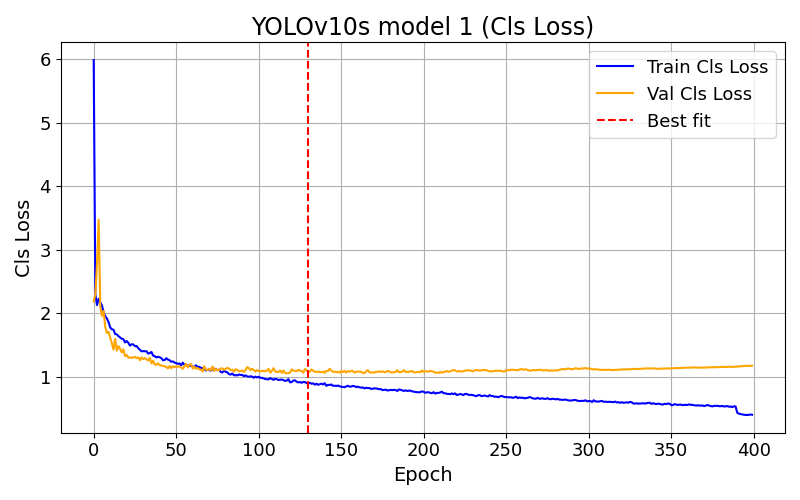

# YOLOv10m

In [30]:
name = "YOLOv10m"
path = os.path.join(name.lower(), "runs/detect")
folders = find_folders(path)
dfs = load_csv_from_folders(folders, path)

In [31]:
folders

['dataset-v2-2', 'dataset-v2-aug', 'dataset-v2-finetune-1', 'train', 'train2']

In [32]:
best_map50(dfs)

,Model,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),fitness,val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
19,Model 1,20.0,1495.11,2.40113,1.08589,2.35363,0.92386,0.90192,0.95455,0.62220,0.655435,2.52240,1.12309,2.46156,0.000074,0.000074,0.000074
140,Model 2,141.0,9949.04,1.66881,0.73536,1.90703,0.94361,0.90100,0.95769,0.63515,0.667404,2.57329,1.11622,2.66578,0.000384,0.000384,0.000384
232,Model 3,233.0,13899.30,1.55569,0.68354,1.86001,0.94985,0.91637,0.96653,0.64422,0.676451,2.49760,0.95397,2.64585,0.000293,0.000293,0.000293
88,Model 4,89.0,6323.48,1.83347,0.80751,1.98745,0.94016,0.90508,0.95648,0.63317,0.665501,2.51405,1.04102,2.52960,0.000161,0.000161,0.000161
74,Model 5,75.0,5308.64,1.57027,0.67811,1.87311,0.95339,0.91016,0.96334,0.64424,0.676150,2.48572,0.98236,2.57048,0.000031,0.000031,0.000031


In [33]:
plot_model_metrics(dfs, name, 110)

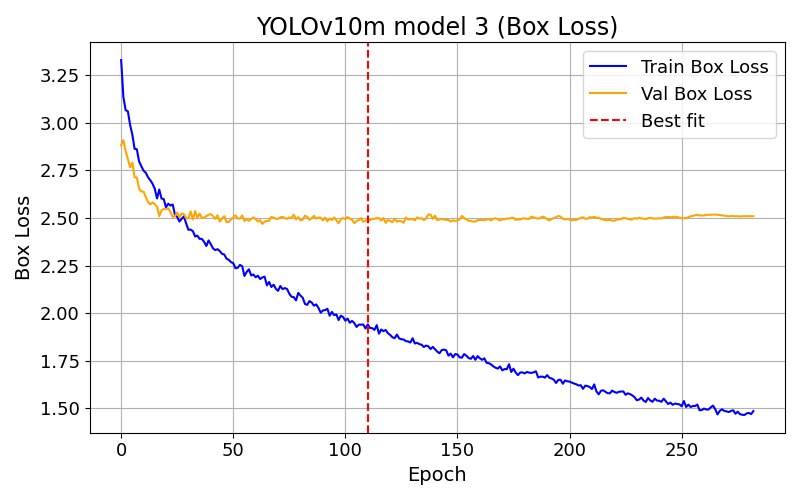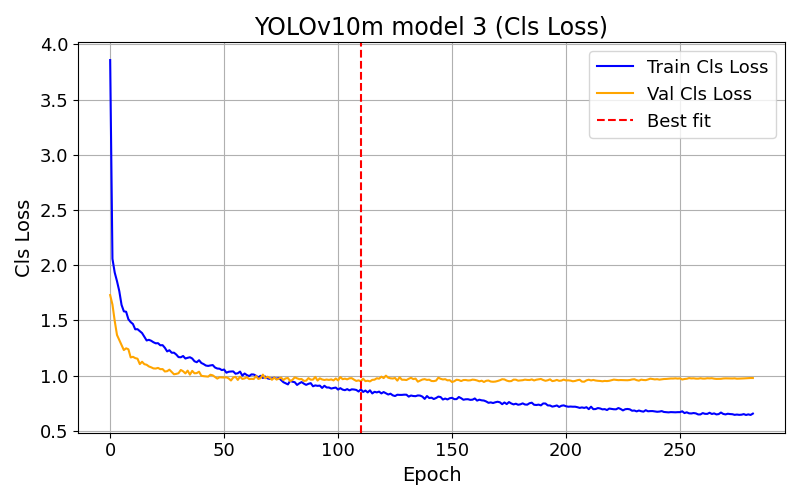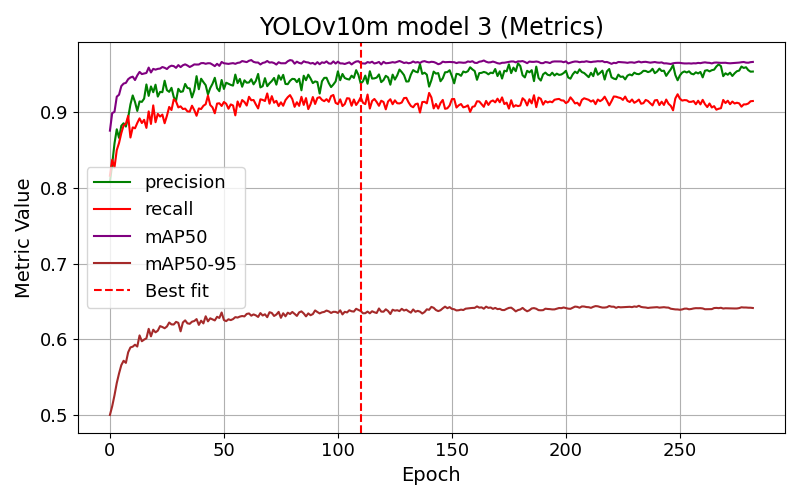

# YOLOv10l

In [34]:
name = "YOLOv10l"
path = os.path.join(name.lower(), "runs/detect")
folders = find_folders(path)
dfs = load_csv_from_folders(folders, path)

In [35]:
folders

['dataset-v2-1',
 'dataset-v2-finetune-1',
 'train',
 'train2',
 'train3',
 'train4']

In [36]:
best_map50(dfs)

,Model,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),fitness,val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
282,Model 1,283.0,31027.10,1.14617,0.50195,1.16591,0.94518,0.90911,0.95928,0.65324,0.683844,2.48727,1.12854,1.83117,0.003021,0.003021,0.003021
170,Model 2,171.0,13271.80,1.57282,0.68143,1.86844,0.95170,0.91704,0.97113,0.64681,0.679242,2.49514,0.98066,2.63871,0.000198,0.000198,0.000198
61,Model 3,62.0,7104.20,2.13382,0.97475,2.11244,0.93652,0.89308,0.95321,0.63229,0.664382,2.52814,1.07451,2.46757,0.000495,0.000495,0.000495
23,Model 4,24.0,2789.83,2.27048,1.02759,2.20525,0.94792,0.90762,0.96538,0.64101,0.673447,2.51545,1.02639,2.43940,0.000105,0.000105,0.000105
89,Model 5,90.0,10427.70,1.38398,0.57114,1.81342,0.95980,0.91308,0.96767,0.65080,0.682487,2.48485,1.00690,2.62164,0.000006,0.000006,0.000006
9,Model 6,10.0,1250.20,4.25136,4.45584,3.35035,0.49613,0.47626,0.46241,0.22527,0.248984,3.84151,NaN,3.31009,0.060791,0.060791,0.060791


In [37]:
plot_model_metrics(dfs, name, 100)

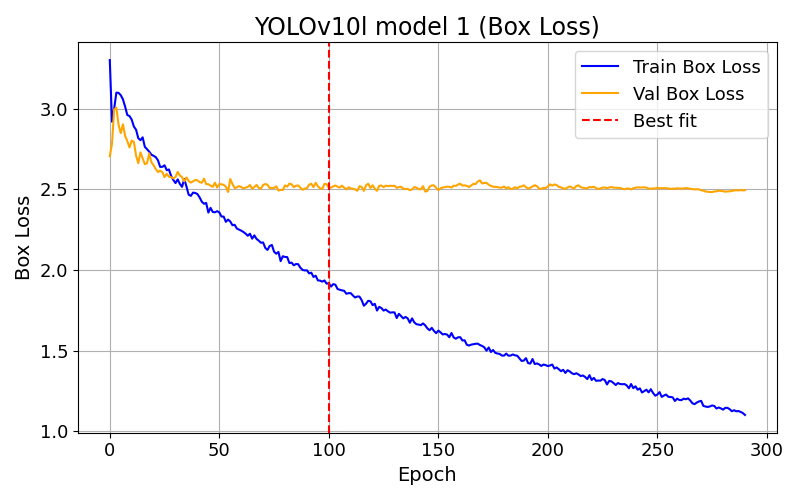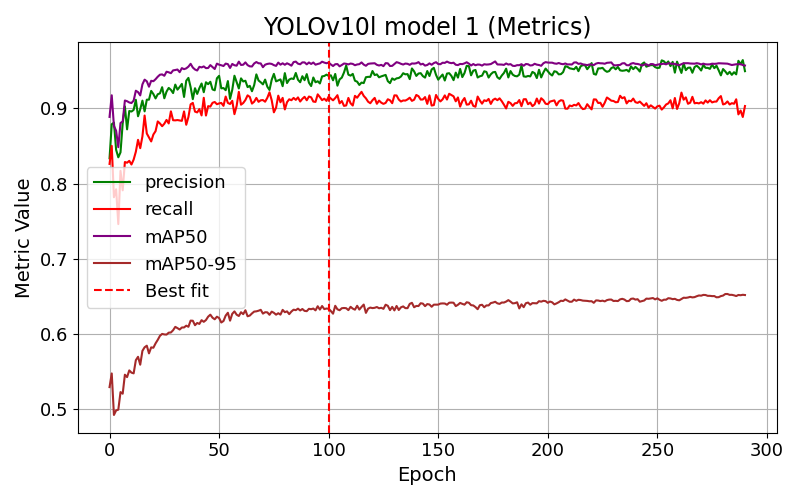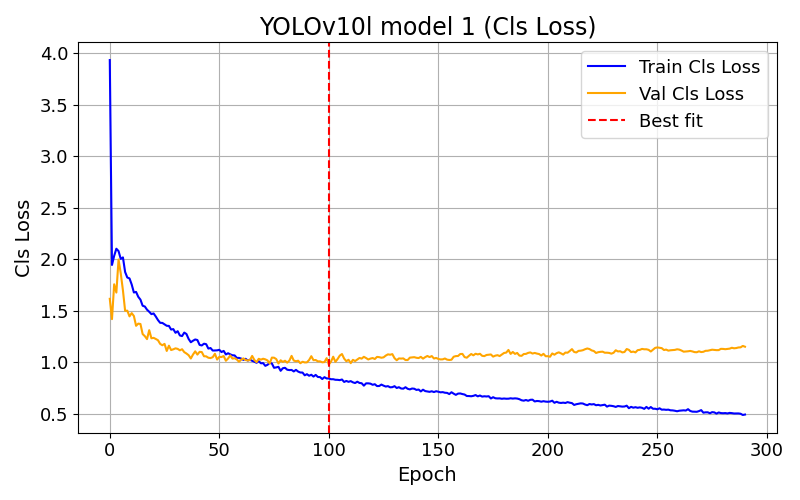

# YOLOv10x

In [38]:
name = "YOLOv10x"
path = os.path.join(name.lower(), "runs/detect")
folders = find_folders(path)
dfs = load_csv_from_folders(folders, path)

In [39]:
folders

['dataset-v2-1', 'dataset-v2-finetune-1', 'train3', 'train4']

In [40]:
best_map50(dfs)

,Model,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),fitness,val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
93,Model 1,94.0,14023.3,1.91366,0.87192,2.03856,0.94290,0.90228,0.95978,0.63318,0.665840,2.52266,1.03054,2.57158,0.000866,0.000866,0.000866
180,Model 2,181.0,18377.6,1.42130,0.61512,1.82653,0.95170,0.91843,0.96646,0.65047,0.682069,2.49388,1.01657,2.70050,0.000136,0.000136,0.000136
266,Model 3,267.0,40299.7,1.04303,0.47240,1.72006,0.95726,0.89290,0.95327,0.63869,0.670148,2.58271,1.19933,2.85079,0.000153,0.000153,0.000153
48,Model 4,49.0,7490.9,1.90291,0.74672,2.07557,0.94610,0.90388,0.95934,0.64009,0.672015,2.50280,1.02402,2.45822,0.000062,0.000062,0.000062


In [41]:
plot_model_metrics(dfs, name, 70)

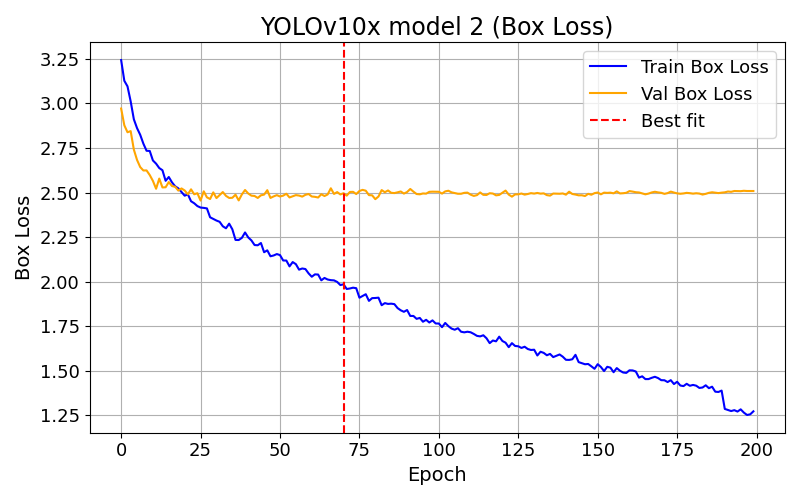

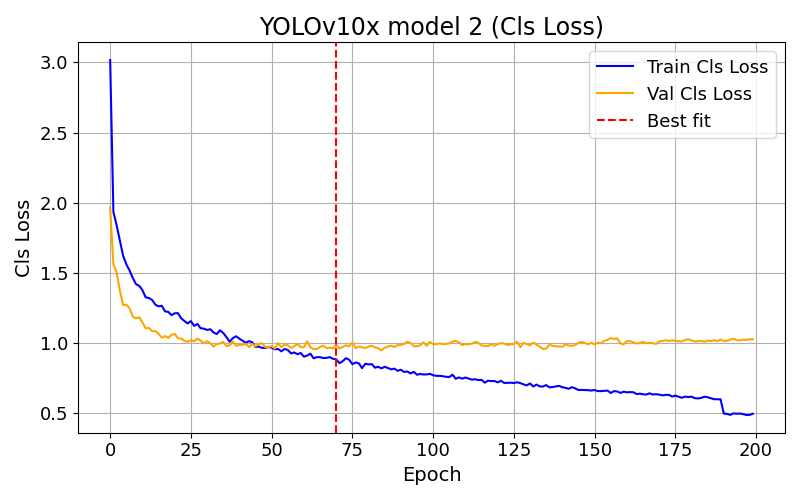

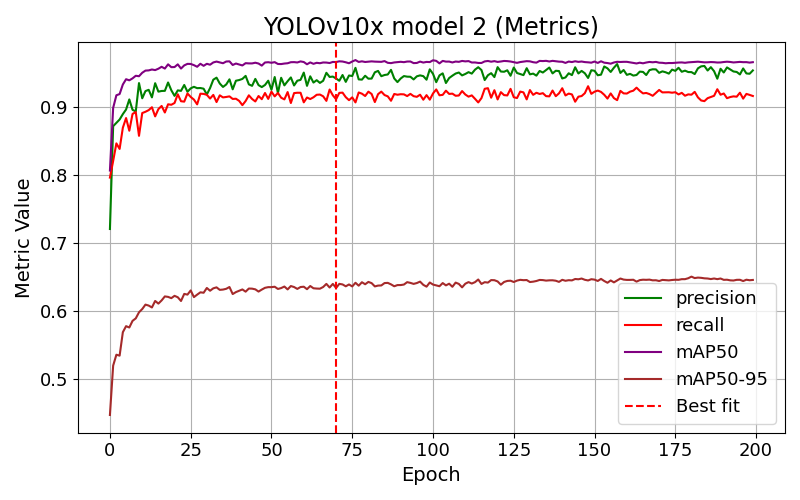